In [115]:
from IPython.display import Markdown
def display_chat(messages):
    """
    Displays messages in a Jupyter Notebook using Markdown formatting.
    Different roles ('system', 'user', 'assistant') are styled differently.
    """

    markdown_output = ""

    for message in messages:
        role = message.get('role')
        content = message.get('content').replace('\n', '  \n')
        if role is None or content is None:
            raise ValueError("Each message must have 'role' and 'content'.")
        if role == 'system':
            markdown_output += f"**System prompt:** {content}\n\n"
        elif role == 'user':
            markdown_output += f"👤: {content}\n\n"
        elif role == 'assistant':
            markdown_output += f"🤖: {content}\n\n"
        else:
            markdown_output += f"Unrecognized role:{role}\n\n"

    # Display formatted markdown
    display(Markdown(markdown_output))

# (Q)LoRA finetuning  

### Training <0.1% of the parameters  

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/peft/lora_diagram.png" alt="drawing" width="600"/>



LoRA injects low rank linear layers (BA) into every linear layer in the architecture. QLoRA is just the addition of quantization to a LoRA model.

Quantization allows to finetune a 7B model on a 4090 by reducing 4x the memory requirements.

Quant reduces model performance, but LoRA is able to mitigate this while also finetuning the model on a downstream task.



## Load the base model

An already finetuned model can be finetuned further, but lets stick to a so-called pretrained model.

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
# Mistral is a base model, not finetuned for any specific task 
model_name = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(
    model_name, device_map="cuda:0", torch_dtype=torch.bfloat16,  quantization_config=nf4_config
)

/shared/raul/mambaforge/envs/llm_slides/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:32<00:00, 16.48s/it]


# Prepare a dataset
Our example finetuning will perform a simple task using SMILES.
For a given SMILES we will instruct the model to produce the same SMILE but reversed.

I have prepared a dataset with some smiles and their reverses. So from `smile` I want to get `smile[::-1]`.

Although this would be more fitting to a sequence to sequence model, we will encode this as a CausalLM task and finetune on it using next token prediction. The 7B model should be powerful enough to handle it anyhow.


In [120]:
import datasets
import pandas as pd
import numpy as np
dsp = pd.read_csv("small_smiles.csv")
dsp.head()

,smiles,rev_smiles
0,C=CC(=O)N1C[C@@H]2CCOc3c(Cl)c(-c4c(O)cccc4F)c(F)c4ncnc(c34)N2C[C@H]1C,C1]H@C[C2N)43c(cncn4c)F(c)F4cccc)O(c4c-(c)lC(c3cOCC2]H@@C[C1N)O=(CC=C
1,COc1ccc2c(c1)OCc1c-2oc2ccccc2c1=O,O=1c2ccccc2co2-c1cCO)1c(c2ccc1cOC
2,COc1ccc2c(c1)NC1=C(C(=O)OC1)C2c1cc(OC)c(OC)c(OC)c1,1c)CO(c)CO(c)CO(cc1c2C)1CO)O=(C(C=1CN)1c(c2ccc1cOC
3,CC[C@@]1(O)C[C@H](OC2CC(N(C)C)C(OC3CC(O)C(OC4CCC(=O)C(C)O4)C(C)O3)C(C)O2)c2c(cc3c(c2O)C(=O)c2c(O...,CO)O=(C1]H@C[)O=3C2cccc)O(c2c)O=(C)O2c(c3cc(c2c)2O)C(C)3O)C(C)4O)C(C)O=(CCC4CO(C)O(CC3CO(C)C)C(N...
4,COc1ccc2c(c1)OC(N)=C(C#N)C2c1cc(OC)c(OC)c(OC)c1,1c)CO(c)CO(c)CO(cc1c2C)N#C(C=)N(CO)1c(c2ccc1cOC


We will create a dataset with labels so that for each `[SMILE]` and `[REV_SMILE]` pair we get:  
`[SMILE]<reversed>[REV_SMILE]<end_of_smile>`  
The tokenizer will prepend each sample with the special token `tokenizer.bos_token` (normally `<s>`) and will place `tokenizer.eos_token` at the end. However, adding our own special separator will help the model.

#### I find that 6K examples are enough for the model to understand the task

In [121]:
subset = 6000
smile_separator = "<reversed>"
smile_end = "<end_of_smile>"
smiles = np.array([s+smile_separator+r+smile_end for s,r in zip(dsp["smiles"][:subset], dsp["rev_smiles"][:subset])])
ds = pd.DataFrame.from_dict({"labels": smiles})
display(ds.head())
ds = datasets.Dataset.from_pandas(ds)

,labels
0,C=CC(=O)N1C[C@@H]2CCOc3c(Cl)c(-c4c(O)cccc4F)c(F)c4ncnc(c34)N2C[C@H]1C<reversed>C1]H@C[C2N)43c(cn...
1,COc1ccc2c(c1)OCc1c-2oc2ccccc2c1=O<reversed>O=1c2ccccc2co2-c1cCO)1c(c2ccc1cOC<end_of_smile>
2,COc1ccc2c(c1)NC1=C(C(=O)OC1)C2c1cc(OC)c(OC)c(OC)c1<reversed>1c)CO(c)CO(c)CO(cc1c2C)1CO)O=(C(C=1C...
3,CC[C@@]1(O)C[C@H](OC2CC(N(C)C)C(OC3CC(O)C(OC4CCC(=O)C(C)O4)C(C)O3)C(C)O2)c2c(cc3c(c2O)C(=O)c2c(O...
4,COc1ccc2c(c1)OC(N)=C(C#N)C2c1cc(OC)c(OC)c(OC)c1<reversed>1c)CO(c)CO(c)CO(cc1c2C)N#C(C=)N(CO)1c(c...


The tokenizer of a model intended for conversation is not really fit for SMILES, so they will tend to be encoded as a really long series of tokens.

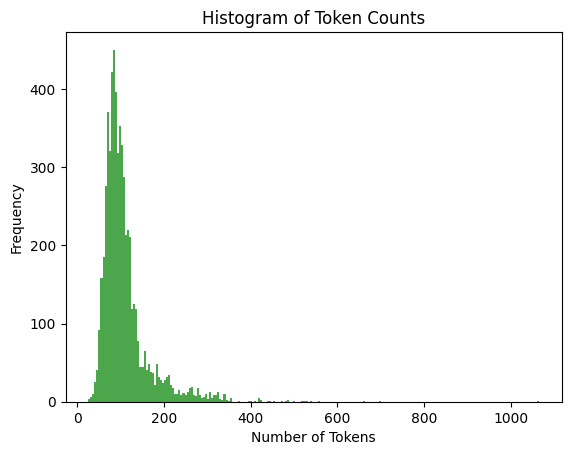

In [122]:
import matplotlib.pyplot as plt
token_counts = [len(tokenizer.encode(text)) for text in smiles]
plt.hist(token_counts, bins='auto', color='green', alpha=0.7)
plt.title('Histogram of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [29]:
train_test = ds.train_test_split(test_size=0.2)
validation = train_test['test'].train_test_split(test_size=0.5)
split_ds = {
        'train': train_test['train'],
        'validation': validation['train'],
        'test': validation['test']
    }

In [7]:
split_ds

{'train': Dataset({
     features: ['labels'],
     num_rows: 2400
 }),
 'validation': Dataset({
     features: ['labels'],
     num_rows: 300
 }),
 'test': Dataset({
     features: ['labels'],
     num_rows: 300
 })}

--------------------------------------
# Adding a LoRA adapter


In [8]:
import peft # Parameter Efficient Finetuning. Contains utilities for adding adapters to HF models
lora_config = peft.LoraConfig(peft_type=peft.TaskType.CAUSAL_LM,
                              inference_mode=False,
                              r=8, # Rank
                              lora_alpha=32,
                              lora_dropout=0.1)
model = peft.get_peft_model(model, lora_config)
display(model.print_trainable_parameters())

trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.04703666202518836


### Inspecting the model reveals that LoRA has been hooked into some of the linear layers

In [9]:
print(model)

PeftModel(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
              )
              (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
         

# Finetuning with the transformers Supervised Finetuning Trainer

In [32]:
from transformers import TrainingArguments
from trl import SFTTrainer
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    num_train_epochs=1,              
    logging_steps=100,
    logging_dir="./logs",            
    output_dir="./results",         
    learning_rate=2e-4,
    max_grad_norm=0.3,
    max_steps=2000,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    remove_unused_columns=False
)
tokenizer.padding_side = 'right'
model = model.to("cuda")
tokenizer.pad_token = tokenizer.eos_token
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=split_ds["train"],
    dataset_text_field="labels",
    tokenizer=tokenizer,
)
torch.cuda.empty_cache()


Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4800/4800 [00:00<00:00, 5866.71 examples/s]


In [33]:
trainer.train()

Step,Training Loss
100,0.825100
200,0.837100
300,0.799900
400,0.746700
500,0.745200
600,0.721900
700,0.680300
800,0.639300
900,0.631700
1000,0.643200


TrainOutput(global_step=2000, training_loss=0.6674249382019043, metrics={'train_runtime': 1024.5176, 'train_samples_per_second': 1.952, 'train_steps_per_second': 1.952, 'total_flos': 9124603172708352.0, 'train_loss': 0.6674249382019043, 'epoch': 0.42})

# Testing the model

Lets try and see how the model behaves for a task by picking a SMILE and asking for its reverse.

In [94]:
i=1
smile = [s.split(smile_end)[0] for s in split_ds["test"][i]["labels"].split(smile_separator)] 
tokens = tokenizer(smile[0]+smile_separator, return_tensors="pt").to("cuda")
display(Markdown(f"**SMILE:** `{smile[0]}`"))
display(Markdown(f"**Reverse:** `{smile[1]}`"))
display(Markdown(f"**Model input:**`{smile[0]+smile_separator}`"))

**SMILE:** `Cc1cccc2c(N)c3cccc(C(=O)NCC[N+](C)(C)Cc4sc(N5CCOCC5)nc4[N+](=O)[O-])c3nc12`

**Reverse:** `21cn3c)]-O[)O=(]+N[4cn)5CCOCC5N(cs4cC)C()C(]+N[CCN)O=(C(cccc3c)N(c2cccc1cC`

**Model input:**`Cc1cccc2c(N)c3cccc(C(=O)NCC[N+](C)(C)Cc4sc(N5CCOCC5)nc4[N+](=O)[O-])c3nc12<reversed>`

## First with the base model

In [98]:
with model.disable_adapter():
   gen_tokens = model.generate(**tokens, max_new_tokens=len(smile[1]))[0]
generated = tokenizer.decode(gen_tokens[tokens["input_ids"].shape[1]:])
display(Markdown("---\n### **Generated**\n------"))
display(Markdown(f"```{generated.split(smile_end)[0]}```"))
display(Markdown("---\n### **Truth**\n------"))
display(Markdown(f"```{smile[1]}```"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


---
### **Generated**
------

```

## Related Resources

- ### 2019-2020 CAS Scholarship

The CAS Scholarship is a merit-based scholarship for students who have demonstrated outstanding academic achievement and leadership.
- ### 2019-2020 CAS Dean's Scholarship

The```

---
### **Truth**
------

```21cn3c)]-O[)O=(]+N[4cn)5CCOCC5N(cs4cC)C()C(]+N[CCN)O=(C(cccc3c)N(c2cccc1cC```

## Now with the finetuned one

In [99]:
gen_tokens = model.generate(**tokens, max_new_tokens=len(smile[1]))[0]
generated = tokenizer.decode(gen_tokens[tokens["input_ids"].shape[1]:])
display(Markdown("### **Generated**\n------"))
display(Markdown(f"```{generated.split(smile_end)[0]}```"))
display(Markdown("### **Truth**\n------"))
display(Markdown(f"```{smile[1]}```"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### **Generated**
------

```21cn3c)]-O[)O=(]+N[4cn)5CCOCC5N(cs4cC)C()C(]+N[CCN)O=(C(cccc3c)N(c2cccc1cC```

### **Truth**
------

```21cn3c)]-O[)O=(]+N[4cn)5CCOCC5N(cs4cC)C()C(]+N[CCN)O=(C(cccc3c)N(c2cccc1cC```

# Saving the adapter

In [124]:
model.save_pretrained("adapters/mistral_smiles_rev")

### The information required to take this 15GB model from nonsense to SMILE reverser is just 14MB! 

In [125]:
!ls -lsrht adapters/mistral_smiles_rev

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


total 14M
8,0K -rw-r--r-- 1 raulp lab 5,9K nov 27 20:48 README.md
 14M -rw-r--r-- 1 raulp lab  14M nov 27 20:48 adapter_model.bin
4,0K -rw-r--r-- 1 raulp lab  600 nov 27 20:48 adapter_config.json
